# Load Data from an Intan RHD file.
### Header information (and saved data, if present) will be stored in the *result* variable. You'll also be able to specify a channel's name to plot its recorded data as an example of accessing data from *result*.

In [1]:
# Load the background Python functions that allow for data loading and plotting
%run importintanutilities.py

### Name of file to load. To load a different file, move it to the same directory as this notebook, and change the following 'filename' variable to point the name of your file.

### Once a file is loaded, all of its information is stored in the *result* variable. If further analysis of this data is desired, this is 

In [2]:
filename = 'sampledata.rhd' # Change this variable to load a different data file
result, data_present = load_file(filename)


Reading Intan Technologies RHD2000 Data File, Version 1.5

Found 32 amplifier channels.
Found 3 auxiliary input channels.
Found 1 supply voltage channel.
Found 2 board ADC channels.
Found 2 board digital input channels.
Found 16 board digital output channels.
Found 1 temperature sensors channel.

File contains 2.016 seconds of data.  Amplifiers were sampled at 20.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
100% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.1 seconds


### Once a file is loaded, all of its information is stored in the *result* variable. If further analysis of recorded data is desired, this is the variable that should be used.

### As an example, the plot_channel function (code in *importintanutilities.py*) accesses *result* to plot a specific channel.

In [3]:
# print_all_channel_names(result) # Uncomment this line and re-run cell to display names of all available channels

<IPython.core.display.Javascript object>


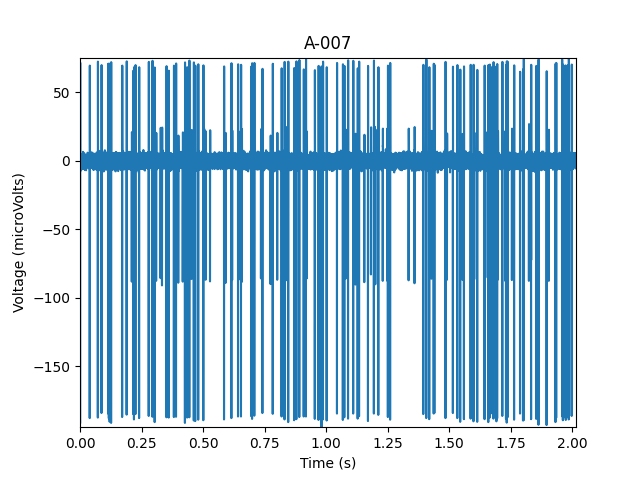

In [4]:
channel_name = 'A-007' # Change this variable and re-run cell to plot a different channel

# Plotted data can be viewed either as a static inline graph, or a dynamic plot that can be zoomed, resized, etc.
# For static plots, only leave '%matplotlib inline' uncommented
# For dynamic plots, only leave '%matplotlib notebook' uncommented
%matplotlib notebook
# %matplotlib inline

if data_present:
    plot_channel(channel_name, result)
    
else:
    print('Plotting not possible; no data in this file')